### 实验3 卷积神经网络实验_残差网络实验

In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from typing import Tuple


def train_epoch(data_loader: Data.DataLoader, net: nn.Module,
                loss_func, optimizer: torch.optim.Optimizer,
                device='cpu'):
    """
    训练迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param optimizer:   优化器
    :param device:      设备
    :return:    loss, acc
    """
    net.train()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    for batch_num, (x, y_true) in enumerate(data_loader):

        # 将数据放入指定的设备
        x = x.to(device).float()
        y_true = y_true.to(device).long()

        # 计算损失
        y_hat: torch.Tensor = net(x)
        loss = loss_func(y_hat, y_true)

        # 取概率最大的类别索引
        y_true: torch.Tensor = y_true.view(-1)
        y_hat = y_hat.argmax(dim=1)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (y_true == y_hat).float().sum().item()
        sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def test_epoch(data_loader: Data.DataLoader,
               net: nn.Module, loss_func, device='cpu'):
    """
    测试函数迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param device:      设备
    :return:    loss, acc
    """
    net.eval()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    with torch.no_grad():

        for batch_num, (x, y_true) in enumerate(data_loader):

            # 将数据放入指定的设备
            x = x.to(device).float()
            y_true = y_true.to(device).long()

            # 计算损失
            y_hat: torch.Tensor = net(x)
            loss = loss_func(y_hat, y_true)

            # 取概率最大的类别索引
            y_true: torch.Tensor = y_true.view(-1)
            y_hat = y_hat.argmax(dim=1)

            total_loss += loss.item()
            correct += (y_true == y_hat).float().sum().item()
            sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def plot_loss_accuracy(train_loss_list, train_acc_list,
                       test_loss_list, test_acc_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    ax2.plot(x, train_acc_list, 'b-', label="train_accuracy", lw=1)
    ax2.plot(x, test_acc_list, 'r-', label="test_accuracy", lw=1)
    ax2.set_title(info + 'Accuracy')
    ax2.legend(loc='best', frameon=False)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("Accuracy")

    plt.show()


def plot_by_dict(metrics: dict, shape: Tuple[int, int]):
    """
    绘制图形 {指标: {参数值名1: [], 参数值名2: []}}
    """
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = list(np.array(axes).ravel())
    fig.set_size_inches(10*shape[0], 6*shape[1])

    colors = ['b', 'r', 'y', 'c', 'k', 'g', 'w', 'm']
    for ax_no, title in enumerate(metrics.keys()):
        ax = axes[ax_no]
        for i, (key, values) in enumerate(metrics.get(title, {}).items()):
            x = np.linspace(0, len(values), len(values))
            ax.plot(x, values, colors[i], label=key, lw=1)
            ax.set_title(title)
            ax.legend(loc='best', frameon=False)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title.lower().split(' ')[-1])

    plt.show()

#### 数据集介绍
分类任务：数据集——车辆分类数据<br>
+ 输入图片，输出对应的类别
+ 共1358张车辆图片
+ 分别属于汽车、客车和货车三类
+ 汽车：779张、客车：218张、 货车：360张
+ 每个类别的后20-30%当作测试集
+ 各图片的大小不一，需要将图片拉伸到相同大小

In [2]:
# data_dir = Path('/Users/zhengchubin/PycharmProjects/learn/data/实验4_check-in轨迹数据/')
data_dir = Path('/root/zhengchubin/data/实验3_数据集/车辆分类数据集')

test_size = 0.25
train_x, train_y, test_x, test_y = [], [], [], []
label2index, index2label = {}, {}
for i, directory in enumerate(data_dir.iterdir()):

    # 读取标签
    label2index[directory.name] = i
    index2label[i] = directory.name

    end_of_train = len([_ for _ in directory.rglob('*.jpg')]) * (1 - test_size)

    for num, file in enumerate(directory.rglob('*.jpg'), start=1):
        img = Image.open(file)
        img = img.resize((120, 100), Image.ANTIALIAS)

        # [H, W, C] = [100, 120, 3]
        img = np.array(img)

        # 转换为 [C, H, W] = [3, 100, 120]
        img = img.transpose(2, 0, 1)

        # 归一化
        img = img / 255

        if num <= end_of_train:
            train_x.append(torch.from_numpy(img))
            train_y.append(i)
        else:
            test_x.append(torch.from_numpy(img))
            test_y.append(i)

train_x, train_y = torch.stack(train_x), torch.Tensor(train_y)
test_x, test_y = torch.stack(test_x), torch.Tensor(test_y)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print('label2index:', label2index)

train_set = torch.utils.data.TensorDataset(train_x, train_y)
test_set = torch.utils.data.TensorDataset(test_x, test_y)


torch.Size([1017, 3, 100, 120]) torch.Size([1017])
torch.Size([340, 3, 100, 120]) torch.Size([340])
label2index: {'bus': 0, 'truck': 1, 'car': 2}


#### ResNets

In [6]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super(ResidualBlock, self).__init__()

        # 卷积堆叠
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3),
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3),
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.short_cut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.short_cut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1),
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """
        输入图片
        :param x:   [batch_size, C_in, H, W]
        :return:
        """
        # 3层卷积 => [batch_size, C_out, H, W]
        output = self.left(x)
        output += self.short_cut(x)
        output: torch.Tensor = F.relu(output)
        return output


class ResNetsModule(nn.Module):

    def __init__(self, output_size: int):
        super(ResNetsModule, self).__init__()

        # 输入 [64, 3, 100, 120]
        self.conv1 = ResidualBlock(3, out_channels=4, stride=1)
        self.conv2 = ResidualBlock(4, out_channels=8, stride=2)
        self.conv3 = ResidualBlock(8, out_channels=16, stride=1)
        self.conv4 = ResidualBlock(16, out_channels=32, stride=2)

        # 输出层
        self.fc = nn.Linear(32, output_size)   # 输出 [64, output_size]

    def forward(self, x):
        """
        输入图片
        :param x:   [batch_size, C_in, H, W]
        :return:
        """
        # 3层卷积 => [batch_size, C_out, H, W]
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)

        # 平均池化 => [batch_size, C_out, 1, 1]
        output: torch.Tensor = F.avg_pool2d(output, kernel_size=(output.shape[-2], output.shape[-1]))

        # 压缩 => [batch_size, C_out]
        output = output.squeeze()
        output: torch.Tensor = self.fc(output)

        return output

ResNetsModule(
  (conv1): ResidualBlock(
    (left): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (short_cut): Sequential(
      (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): ResidualBlock(
    (left): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

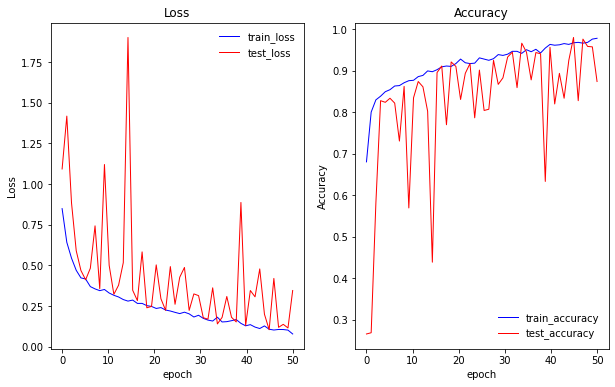

In [7]:
batch_size = 64
output_size = len(label2index)
num_epochs = 50
lr = 0.001
device = 'cpu'

net = ResNetsModule(output_size=output_size).to(device)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)